In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import pyro
import pyro.distributions as dist

import functools

In [2]:
import sys; sys.path.append('/Users/big/lib/pyro/examples/rsa/')
from search_inference import HashingMarginal, Search

In [3]:
def flip(p=0.5):
    return torch.distributions.Bernoulli(p).sample()

def pflip(p=0.5, var='flip'):
    return pyro.sample(var, dist.Bernoulli(p))

def repeat(f, n):
    return [f() for _ in range(n)]

def memoize(fn=None, **kwargs):
    if fn is None:
        return lambda _fn: memoize(_fn, **kwargs)
    return functools.lru_cache(**kwargs)(fn)

def viz(data, to_type=(lambda v: v), plot_args={}):
    # Histogram
    if type(data) in (list, torch.Tensor):
        data = [to_type(d) for d in data]
        return plt.hist(data, weights=np.ones(len(data))/float(len(data)), **plot_args)
    
    if isinstance(data, pyro.distributions.Distribution):
        d = {to_type(s): float(data.log_prob(s).exp()) for s in data.enumerate_support()}
        return plt.bar(*zip(*d.items()))
    
def Infer(model, num_samples=1000, hashing=False):
    posterior = pyro.infer.Importance(model, num_samples=num_samples)
    if hashing:
        marginal = HashingMarginal(posterior.run())
        samples = [marginal.sample() for _ in range(num_samples)]
    else:
        marginal = pyro.infer.EmpiricalMarginal(posterior.run())
        samples = marginal.sample(torch.Size([num_samples]))
    return samples

def viz_table(samples):
    count_dict = {h: samples.count(h) / float(len(samples)) for h in set(samples)}
    return pd.DataFrame({
        'hypothesis': list(count_dict.keys()),
        'prob': list(count_dict.values())
    }).sort_values(by='prob', ascending=False)

In [4]:
from pyro import poutine
from six.moves import queue

def sequential_discrete_marginal(model, 
#                                  data,  # TODO
                                 max_samples=10000, 
                                 site_name="_RETURN"):
    
    from six.moves import queue  # queue data structures
    q = queue.Queue()  # Instantiate a first-in first-out queue
    q.put(poutine.Trace())  # seed the queue with an empty trace
    
#     # as before, we fix the values of observed random variables with poutine.condition
#     # assuming data is a dictionary whose keys are names of sample sites in model
#     conditioned_model = poutine.condition(model, data=data)
    
    # we wrap the conditioned model in a poutine.queue,
    # which repeatedly pushes and pops partially completed executions from a Queue()
    # to perform breadth-first enumeration over the set of values of all discrete sample sites in model
    ### enum_model = poutine.queue(conditioned_model, queue=q)
    enum_model = poutine.queue(model, queue=q)
    
    # actually perform the enumeration by repeatedly tracing enum_model
    # and accumulate samples and trace log-probabilities for postprocessing
    samples, log_weights = [], []
    while (not q.empty()) and (len(samples) < max_samples):
        trace = poutine.trace(enum_model).get_trace()
        samples.append(trace.nodes[site_name]["value"])
        log_weights.append(trace.log_prob_sum())
        
    print('len samples ',len(samples))
    print(samples)
    print(log_weights)
        
    # we take the samples and log-joints and turn them into a histogram:
    samples = torch.stack(samples, 0)
    log_weights = torch.stack(log_weights, 0)
    log_weights = log_weights - dist.util.logsumexp(log_weights, dim=0)
    return dist.Empirical(samples, log_weights)

In [5]:
def Infer(model, 
          posterior_method='enumerate', 
          posterior_kwargs=dict(),
          marginal_method='hashing',
          marginal_kwargs=dict(),
          num_samples=1000,
):   # currently unused
    
    if posterior_method == 'enumerate':
        # TODO: test this
        posterior = Search(model, max_tries=num_samples, 
                           **posterior_kwargs)   # method: 'DFS' | 'BFS' 
#     elif posterior_method == 'enumerate2':
#         # TODO: test this
#         marginal = sequential_discrete_marginal(model, max_samples=num_samples, site_name="_RETURN")
    elif posterior_method == 'importance':
        posterior = pyro.infer.Importance(model, num_samples=num_samples, 
                                          **posterior_kwargs)
    else:
        raise ValueError("Posterior method not defined for: {}".format(posterior_method))
        
    if marginal_method == 'empirical':
        marginal = pyro.infer.EmpiricalMarginal(posterior.run())
        samples = marginal.sample(torch.Size([num_samples]))
        
    elif marginal_method == 'hashing':
        marginal = HashingMarginal(posterior.run())
        samples = [marginal.sample() for _ in range(num_samples)]
    else:
        raise ValueError("Marginal method not defined for: {}".format(marginal_method))

    return samples


# model: binomial,
#   method: 'enumerate',
#   maxExecutions: maxExec, 
#   strategy: 'breadthFirst'

len samples  8
[tensor(0.), tensor(1.), tensor(1.), tensor(2.), tensor(1.), tensor(2.), tensor(2.), tensor(3.)]
[tensor(-2.0794), tensor(-2.0794), tensor(-2.0794), tensor(-2.0794), tensor(-2.0794), tensor(-2.0794), tensor(-2.0794), tensor(-2.0794)]


(array([12433.,     0.,     0., 37434.,     0.,     0., 37546.,     0.,
            0., 12587.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ],
       dtype=float32),
 <a list of 10 Patch objects>)

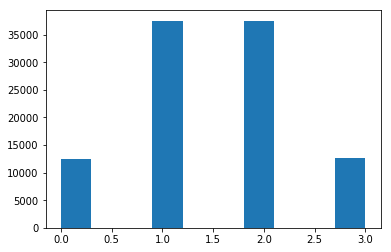

In [91]:
### TODO: testing search . . . . . 

def model():
    A = pflip(var='a')
    B = pflip(var='b')
    C = pflip(var='c')
    return A + B + C

# make the marginal distributions on return values explicit
num_samples = 1000

# posterior = pyro.infer.Importance(model, num_samples=num_samples)
# marginal = pyro.infer.EmpiricalMarginal(posterior.run())

marginal = sequential_discrete_marginal(model, max_samples=8)

samples = marginal.sample(torch.Size([int(1e5)]))

plt.hist(samples, bins=10)

In [8]:
def factor(name, value):
    """Add a scalar weight to the log-probability of the trace."""
    value = value if torch.is_tensor(value) else torch.Tensor([value])
    d = dist.Bernoulli(logits=value)
    pyro.sample(name, d, obs=torch.ones((value.size() or 1)))
    
def condition(name, cond):
    value = (-99999 if cond else 0)
    d = dist.Bernoulli(logits=value)
    pyro.sample(name, d, obs=torch.ones(1))
    
def uniform_draw(items):
    N = torch.ones(len(items))
    idx = dist.Categorical(N).sample()
    return items[idx]

# Learning in a LOT

In [15]:
def random_constant():
    return uniform_draw(range(10))

def random_combination(f, g):
    op = uniform_draw(['+','-','*','/','^'])
    return  f'({f}{op}{g})'

# sample an arithmetic expression
def random_arithmetic_expression():
    if flip(0.3): 
        return random_combination(random_arithmetic_expression(), random_arithmetic_expression())
    else:
        return random_constant()

# viz.table(Infer({method: 'enumerate', maxExecutions: 100}, function() {
#   return randomArithmeticExpression()
# }))
    
[random_arithmetic_expression() for _ in range(10)]

['(3/3)', 2, 4, 9, 6, 7, 3, 2, 0, 5]

TypeError: expected Tensor as element 0 in argument 0, but got int

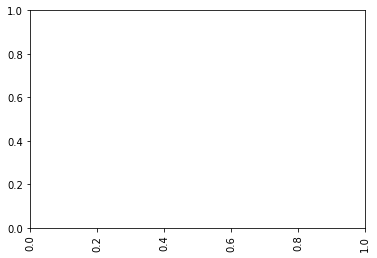

In [17]:
plt.xticks(rotation=90)
# viz(Infer(random_arithmetic_expression, num_samples=10000))

viz(Infer(
    random_arithmetic_expression, 
    posterior_method='importance', 
#     posterior_kwargs=dict({'method': 'DFS'}),
    marginal_method='empirical',
    marginal_kwargs=dict(),
    num_samples=100
), plot_args={'bins': 20})

# TODO: testing...

NameError: name 'random_arithmetic_expression' is not defined

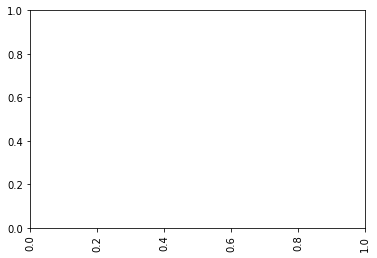

In [6]:
plt.xticks(rotation=90)
# viz(Infer(random_arithmetic_expression, num_samples=10000))

viz(Infer(
    random_arithmetic_expression, 
    posterior_method='importance', 
#     posterior_kwargs=dict({'method': 'DFS'}),
    marginal_method='hashing',
    marginal_kwargs=dict(),
    num_samples=50
), plot_args={'bins': 20})

(array([0.06, 0.14, 0.06, 0.  , 0.08, 0.04, 0.  , 0.02, 0.08, 0.  , 0.06,
        0.1 , 0.14, 0.  , 0.04, 0.08, 0.  , 0.06, 0.02, 0.02]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ,
         7.7,  8.4,  9.1,  9.8, 10.5, 11.2, 11.9, 12.6, 13.3, 14. ]),
 <a list of 20 Patch objects>)

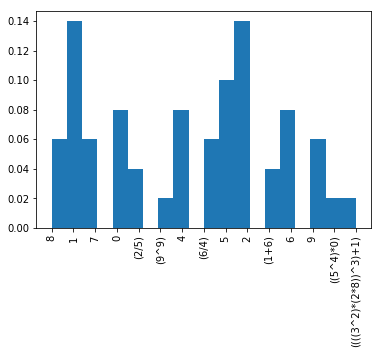

In [25]:
plt.xticks(rotation=90)
# viz(Infer(random_arithmetic_expression, num_samples=10000))

viz(Infer(
    random_arithmetic_expression, 
    posterior_method='importance', 
#     posterior_kwargs=dict({'method': 'DFS'}),
    marginal_method='hashing',
    marginal_kwargs=dict(),
    num_samples=50
), plot_args={'bins': 20})

In [10]:
samples = Infer(random_arithmetic_expression, num_samples=10000, hashing=True)

count_dict = {h: samples.count(h) / float(len(samples)) for h in set(samples)}
pd.DataFrame({
    'hypothesis': list(count_dict.keys()),
    'prob': list(count_dict.values())
}).sort_values(by='prob', ascending=False)

,hypothesis,prob
0,0,0.0779
3,3,0.0747
1,1,0.0714
7,7,0.0713
8,8,0.0700
6,6,0.0682
4,4,0.0666
5,5,0.0666
9,9,0.0636
2,2,0.0621


In [95]:
import sys; sys.path.append('/Users/big/lib/pyro/examples/rsa/')
from search_inference import HashingMarginal

In [104]:
%debug

> <ipython-input-100-8b08b4ac08d9>(31)Infer()
     28         marginal = HashingMarginal(posterior.run())
     29     else:
     30         marginal = pyro.infer.EmpiricalMarginal(posterior.run())
---> 31     samples = marginal.sample(torch.Size([num_samples]))
     32     return samples

ipdb> marginal.sample()
9
ipdb> [marginal.sample() for _ in range(10)]
*** NameError: name 'marginal' is not defined
ipdb> [marginal.sample() for _ in range(10)]
*** NameError: name 'marginal' is not defined
ipdb> marginal
ipdb> [marginal.sample() for _ in range(10)]
*** NameError: name 'marginal' is not defined
ipdb> for _ in range(10: marginal.sample()
*** SyntaxError: invalid syntax
ipdb> for _ in range(10): marginal.sample()
0
8
8
7
'(7^(1+2))'
9
1
4
0
'(6+(7/1))'
ipdb> q


In [94]:
%debug

> /Users/big/lib/pyro/pyro/infer/abstract_infer.py(55)_get_samples_and_weights()
     53         weights_by_chain = []
     54         for i in range(num_chains):
---> 55             samples = torch.stack(self._samples_buffer[i], dim=0)
     56             samples_by_chain.append(samples)
     57             weights_dtype = samples.dtype if samples.dtype.is_floating_point else torch.float32

ipdb> u
> /Users/big/lib/pyro/pyro/infer/abstract_infer.py(41)__init__()
     39         self._weights_buffer = defaultdict(list)
     40         self._populate_traces(trace_posterior, sites)
---> 41         samples, weights = self._get_samples_and_weights()
     42         super(EmpiricalMarginal, self).__init__(samples,
     43                                                 weights,

ipdb> u
> <ipython-input-81-a0d15087729f>(27)Infer()
     25 def Infer(model, num_samples=1000):
     26     posterior = pyro.infer.Importance(model, num_samples=num_samples)
---> 27     marginal = pyro.infer.Empiri

In [78]:
%debug

> <ipython-input-76-42a3123eb544>(64)model()
     62 
     63     # TODO: what is this??
---> 64     mapData({data: data}, obsFn)
     65 
     66     # return posterior predictive

ipdb> u
> /Users/big/lib/pyro/pyro/poutine/messenger.py(27)_wraps()
     25         def _wraps(*args, **kwargs):
     26             with self:
---> 27                 return fn(*args, **kwargs)
     28         _wraps.msngr = self
     29         return _wraps

ipdb> q


In [ ]:
# TODO: version that tracks depth, and expansions get less likely with depth

# Example: Inferring an Arithmetic Expression

In [71]:
# # make expressions easier to look at
# var prettify = function(e) {
#   if (e == 'x' || _.isNumber(e)) {
#     return e
#   } else {
#     var op = e[0]
#     var arg1 = prettify(e[1])
#     var prettyarg1 = (!_.isArray(e[1]) ? arg1 : '(' + arg1 + ')')
#     var arg2 = prettify(e[2])
#     var prettyarg2 = (!_.isArray(e[2]) ? arg2 : '(' + arg2 + ')')
#     return prettyarg1 + ' ' + op + ' ' + prettyarg2
#   }
# }

op_dict = {
    '+': lambda a, b: a + b,
    '*': lambda a, b: a * b,
    '/': lambda a, b: int(a / b),
    '-': lambda a, b: a - b,
    '^': lambda a, b: int(a ** b),
}

def eval_expr(expr):
    # Evaluate `expr` to be a function with 1 arg
    if (expr == 'x'):
        return lambda x: x
    elif type(expr) is not str:  # if expr is number
        return lambda _: expr
    else:
        op, f, g = expr
        f_eval = eval_expr(f)
        g_eval = eval_expr(g)
        op_eval = op_dict[op]
        return lambda z: op_eval(f_eval(z), g_eval(z))

def random_constant():
    return uniform_draw(range(10))

def random_combination(f, g):
    op = uniform_draw(['+','-','*','/','^'])
    return  op, f, g


# sample an arithmetic expression
def random_arithmetic_expression():
    if flip(0.3):
        return random_combination(random_arithmetic_expression(), random_arithmetic_expression())
    elif flip():
        return 'x'
    else:
        return random_constant()

# def model():
#     e = random_arithmetic_expression()
#     s = prettify(e)
#     f = runify(e)
#     condition(f(1) == 3)

#     return {s: s};

# viz.table(Infer(model))
    
[random_arithmetic_expression() for _ in range(10)]

[1,
 1,
 'x',
 2,
 6,
 'x',
 9,
 ('^',
  5,
  ('-',
   ('*',
    ('*',
     'x',
     ('+',
      ('-',
       ('+',
        'x',
        ('*', ('+', 9, ('+', 'x', 7)), ('^', ('+', 9, 'x'), ('-', 0, 4)))),
       5),
      ('+', 'x', 3))),
    'x'),
   ('/', 5, ('+', 9, ('/', 'x', 'x'))))),
 6,
 ('/',
  ('-', 1, 'x'),
  ('+', ('*', ('*', 'x', ('-', 'x', 4)), ('*', 9, 'x')), ('+', 'x', 'x')))]

# Example: Rational Rules

In [ ]:
# TODO: required new primitives
expectation
mapData


In [76]:
# first set up the training and test data:
numFeatures = 4

def make_obj(l): 
    return zip(['trait1', 'trait2', 'trait3', 'trait4', 'fep'], l)

feps = [make_obj(i) for i in    [[0,0,0,1, 1], [0,1,0,1, 1], [0,1,0,0, 1], [0,0,1,0, 1], [1,0,0,0, 1]]]
non_feps = [make_obj(i) for i in [[0,0,1,1, 0], [1,0,0,1, 0], [1,1,1,0, 0], [1,1,1,1, 0]]]
others = [make_obj(i) for i in  [[0,1,1,0],    [0,1,1,1],    [0,0,0,0],    [1,1,0,1], 
                                 [1,0,1,0],    [1,1,0,0],    [1,0,1,1]]]
data = feps.append(non_feps)
all_objs = others + [feps, non_feps]

# here are the human results from Nosofsky et al, for comparison:
human_feps = [.77, .78, .83, .64, .61]
human_non_feps = [.39, .41, .21, .15]
human_other = [.56, .41, .82, .40, .32, .53, .20]
human_data = human_other + [human_feps, human_non_feps]


# two parameters: stopping probability of the grammar, and noise probability:
stop_prob = 0.3
noise_param = np.exp(-1.5)



# a generative process for disjunctive normal form propositional equations:
def sample_pred():
    trait = uniform_draw(['trait1', 'trait2', 'trait3', 'trait4'])
    value = flip()
    return lambda x: x[trait] == value

def sample_conj():
    if(flip(stop_prob)):
        c = sample_conj()
        p = sample_pred()
        return lambda x: c(x) and p(x)
    else:
        return sample_pred()

def get_formula():
    if(flip(stop_prob)):
        c = sample_conj()
        f = get_formula()
        return lambda x: c(x) or f(x)
    else:
        return sample_conj()





def model():
    # sample a classification formula
    rule = get_formula()

    # condition on correctly (up to noise) accounting for observations
    def obs_fn(datum):
        d = Bernoulli((1 - noise_param) if rule(datum) else noise_param)
        v = datum.fep == 1
        return pyro.sample('obs_fn', d, obs=v)
    
    # TODO: what is mapData??
    mapData({data: data}, obs_fn) 

    # return posterior predictive
    return map(rule, all_objs)
    
    
    
    
rule_posterior = Infer(model)

# build predictive distribution for each item
predictives = [expectation(rule_posterior, lambda x: x[i]) for i in range(15)]

viz.scatter(predictives, humanData)

NameError: name 'mapData' is not defined